<a href="https://colab.research.google.com/github/stootoon/first-course-rmt/blob/main/Ex1_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1.2.4 Random Matrices

## Random real symmetric matrix $M$

If $M$ is a random real symmetric orthogonal matrix, then its eigenvalues will be real. Any such eigenvalue will satisfy $$ M v = \lambda v.$$ Multiplying both sides by $M^T$ and applying orthogonality and symmetry, we get $$M^T M v = v = \lambda M^T v = \lambda M v \implies Mv = \lambda^{-1} v \implies \lambda = \lambda^{-1} \implies \lambda= \pm 1.$$

## $P_+$ as a projector
As we saw above $M$'s eigenvalues are either +1 or -1. Let $U_+$ be the matrix whose columns are the eigenvectors with +1 eigenvalue, and $U_-$ be the others. These form an orthonormal basis for $R^N$, so we can decompose any vector $v$ as $$ v = U_+ U_+^T v + U_- U_-^T v = U_+ v_+ + U_- v_-.$$ We can write the matrix $M$ in these terms as $$ M = \sum_i U_i U_i^T \lambda_i = U_+ U_+^T - U_- U_-^T.$$  Then $$P_+ v = {1 \over 2} (M + I) v = {1 \over 2} \left((U_+ v_+ - U_- v_-) + (U_+ v_+ + U_- v_-)\right) = U_+ v_+ = U_+ U_+^T v.$$ Hence $P_+$ projects any vector onto the positive eigenspace of $M$. In particular, it sends eigenvectors of $M$ with positive eigenvalues to themselves, and squashes those with negative eigenvalues to 0.

## Computations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_rand_sym(N):
  ee = np.sign(np.random.randn(N))
  U = np.linalg.qr(np.random.randn(N, N))[0]
  return U @ np.diag(ee) @ U.T

In [5]:
def gen_wigner_sym(N, sd):
  H = np.random.randn(N,N)
  return sd * (H + H.T)/np.sqrt(2*N)

In [62]:
def gen_E(N, sd):
    M = gen_rand_sym(N)
    X = gen_wigner_sym(N, sd)
    return M + X, M, X 

In [58]:
from collections import namedtuple
from tqdm import tqdm

In [95]:
Record = namedtuple('Record', ['evals', 'pv_n', 'err0','err1','err2'])
N = 200
I = np.eye(N)
sd_vals = [0.1,0.5,1.0]
n_sd = len(sd_vals)
n_samps = 101
data = []
evals, pv_n = np.zeros((2, n_samps, N))
err0,err1,err2 = np.zeros((3, n_samps))
for sd in sd_vals:
    for i in tqdm(range(n_samps)):
        E, M, X = gen_E(N, sd) 
        P = (M + I)/2 
        evals[i], V = np.linalg.eigh(E)
        pv_n[i] = np.sum((P @ V)**2, axis=0)
        M0 = 0 * M
        M1 = E
        # My adhoc estimator: 
        s = np.sign(evals[i]) # Denoise eigenvalues by taking their signs
        M2 = V @ np.diag(s) @ V.T # Use the noisy eigenvectors with denoised eigenvalues
        err0[i], err1[i], err2[i] = [np.sum((M - Mest)**2)/N for Mest in [M0, M1, M2]]
    data.append(Record(evals=evals.copy(), pv_n=pv_n.copy(), err0=err0.copy(), err1=err1.copy(), err2=err2.copy()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 70.52it/s]


## (a) Histogram of the eigenvalues of E

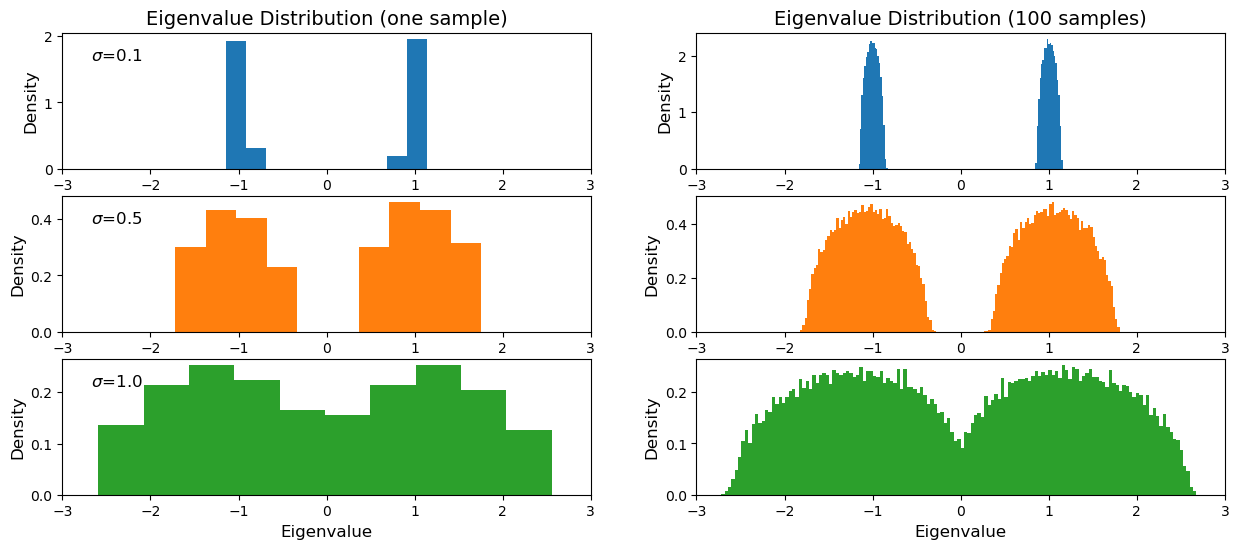

In [70]:
fig, ax = plt.subplots(n_sd, 2, figsize=(15, 2*n_sd))
xl = (-3., 3.)
for i, sd in enumerate(sd_vals):  
    ax[i,0].hist(data[i].evals[0], bins=10, density=True, label = f"$\\sigma$={sd}", color=f"C{i}")
    ax[i,0].set_xlim(xl)
    ax[i,0].legend(loc="upper left", frameon=False, fontsize=12, handlelength=0)
    ax[i,0].set_ylabel("Density", fontsize=12)
    i == 0 and ax[i,0].set_title("Eigenvalue Distribution (one sample)", fontsize=14)
    e_rest = np.array(data[i].evals[1:]).flatten()
    ax[i,1].hist(e_rest, bins=int(np.sqrt(len(e_rest))), density=True, color=f"C{i}")
    ax[i,1].set_xlim(xl)
    ax[i,1].set_ylabel("Density", fontsize=12)
    i == 0 and ax[i,1].set_title("Eigenvalue Distribution (100 samples)", fontsize=14)
    i == n_sd - 1 and [ax[i,j].set_xlabel("Eigenvalue", fontsize=12) for j in [0,1]]

## (b) Non-zero density near 0
From the above this seems to occur as $\sigma$ gets close to 1.

## (c) Norm of $P_+ v_i$

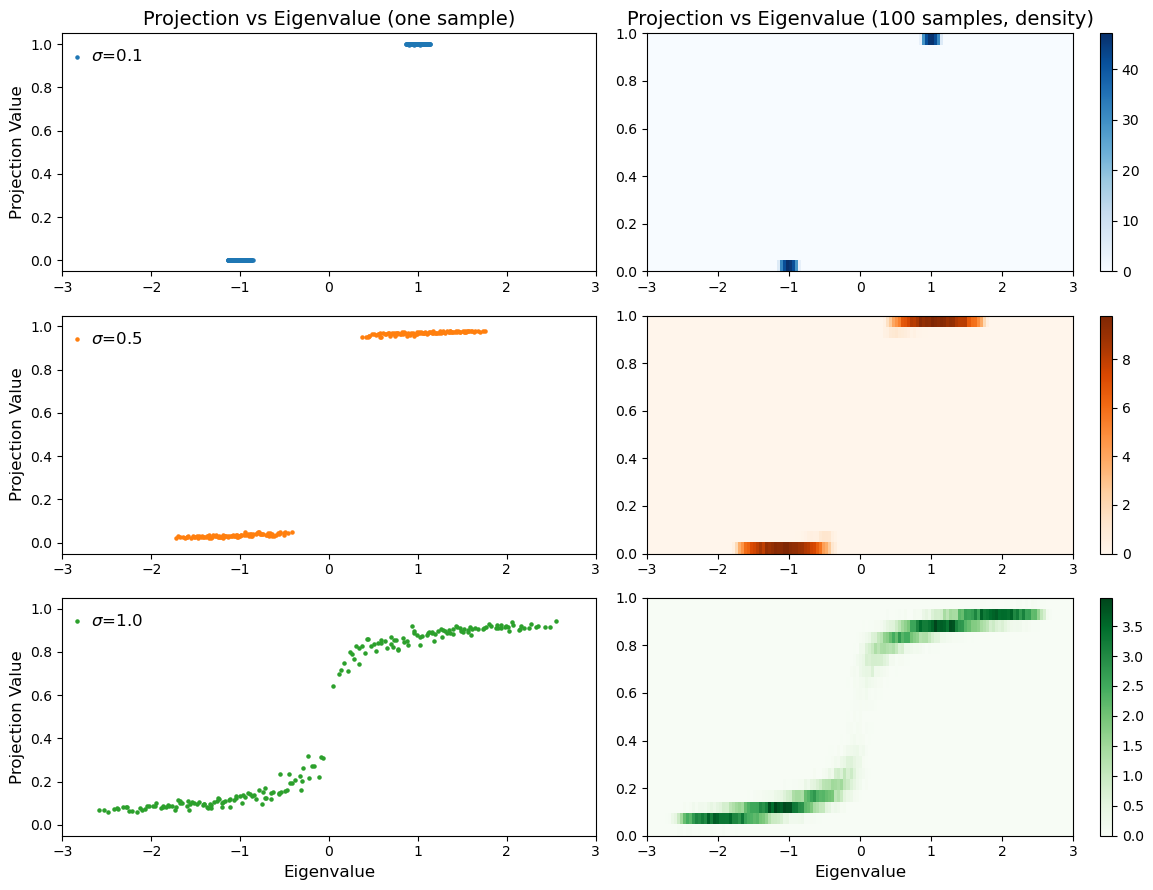

In [89]:
fig, ax = plt.subplots(n_sd, 2, figsize=(12, 3*n_sd))
for i, (d, sd) in enumerate(zip(data, sd_vals)):
    ax[i, 0].scatter(d.evals[0], d.pv_n[0], s=5, color=f"C{i}", label=f"$\\sigma$={sd}")
    ax[i, 0].set_ylim(-0.05,1.05)
    ax[i, 0].set_xlim(xl)
    ax[i, 0].legend(loc="upper left", frameon=False, fontsize=12, handlelength=0)
    ax[i, 0].set_ylabel("Projection Value", fontsize=12) 
    i == 0 and ax[i, 0].set_title("Projection vs Eigenvalue (one sample)", fontsize=14)
    e_rest = np.array(d.evals[1:]).flatten()
    pv_rest = np.array(d.pv_n[1:]).flatten()
    h = ax[i, 1].hist2d(e_rest, pv_rest, bins=[int(np.sqrt(len(e_rest))), 21], range=[xl, (0,1)], density=True, cmap=['Blues', 'Oranges', 'Greens'][i])
    fig.colorbar(h[3], ax=ax[i,1])
    (i == len(data) - 1) and [ax[i, j].set_xlabel("Eigenvalue", fontsize=12) for j in [0,1]]
    i==0 and ax[i, 1].set_title("Projection vs Eigenvalue (100 samples, density)", fontsize=14)
plt.tight_layout()

## (d) Estimator performance

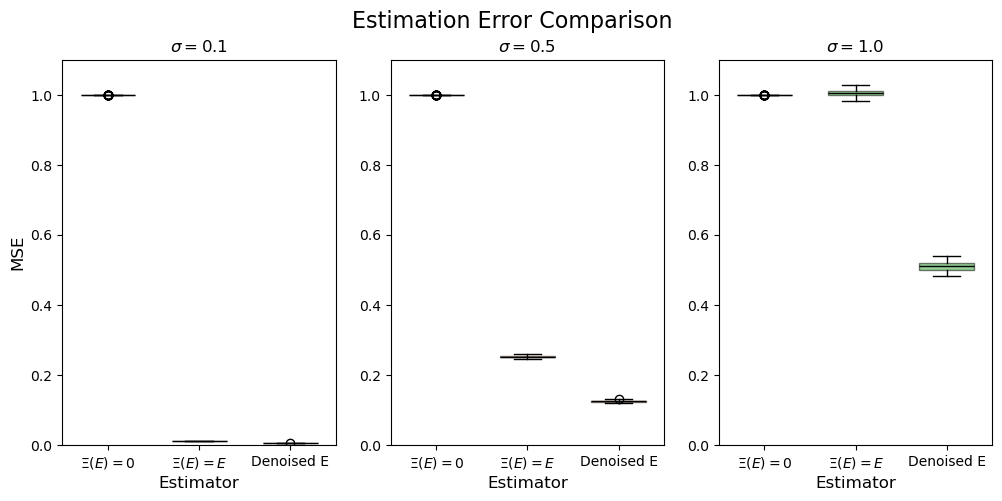

In [112]:
fig, ax = plt.subplots(1, n_sd, figsize=(4*n_sd, 5))
for i, (d, sd) in enumerate(zip(data, sd_vals)):
    ax[i].boxplot([d.err0, d.err1, d.err2], positions=[0,1,2], widths=0.6, patch_artist=True,
                  boxprops=dict(facecolor=f"C{i}", alpha=0.5),
                  medianprops=dict(color='black'))
    ax[i].set_xticks([0,1,2])
    ax[i].set_xticklabels(['$\\Xi(E)=0$', '$\\Xi(E)=E$', 'Denoised E'])
    i == 0 and ax[i].set_ylabel(f"MSE", fontsize=12)
    ax[i].set_title(f"$\\sigma = {sd}$", fontsize=12)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_xlabel("Estimator", fontsize=12)
fig.suptitle("Estimation Error Comparison", fontsize=16);

## (e) Eigenvalues are not IID

In [119]:
inds = np.arange(N-1)
in_bulk = ((inds > 0.2*N) & (inds < 0.3*N)) | ((inds > 0.7*N) & (inds < 0.8*N))

In [120]:
compute_gap = lambda de: np.diff(np.sort(de, axis=1), axis=1)
gaps = [compute_gap(d.evals)[:, in_bulk] for d in data]
shuff_evals = lambda e: np.random.permutation(e.flatten()).reshape(e.shape)
gaps_sh = [compute_gap(shuff_evals(d.evals))[:, in_bulk] for d in data]

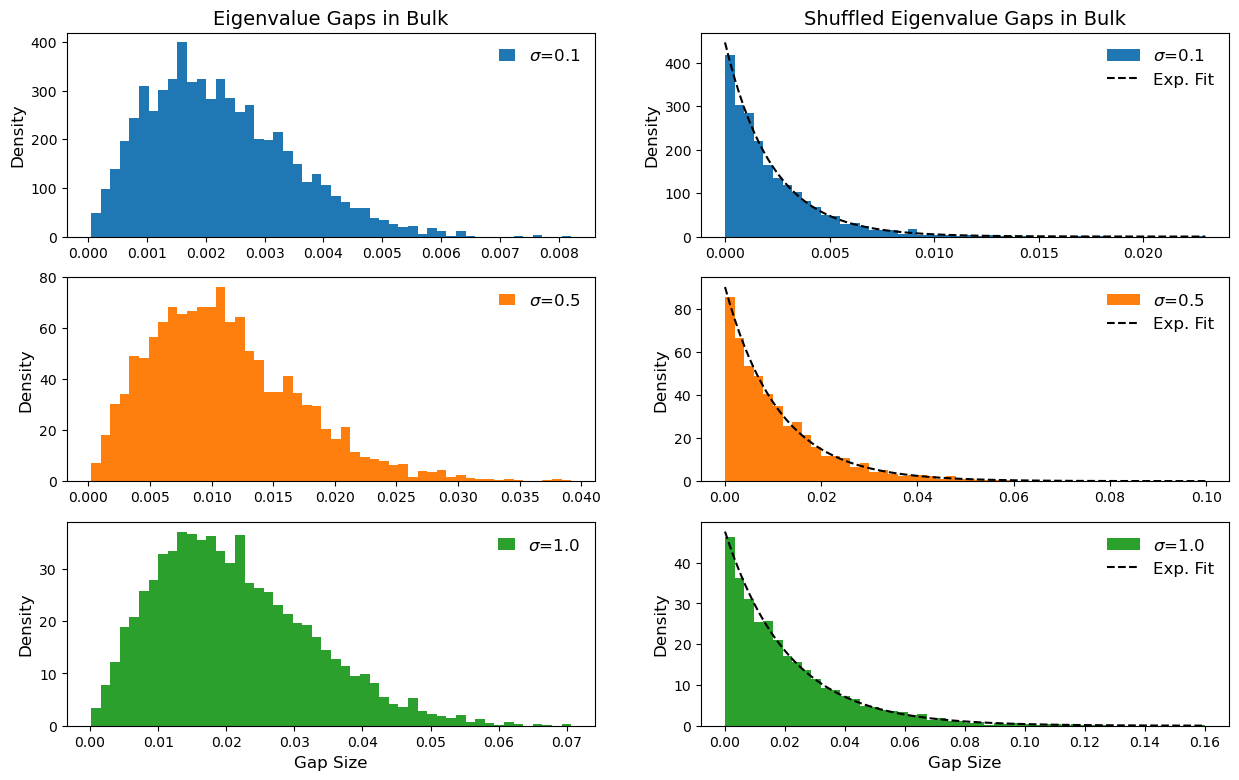

In [133]:
fig, ax = plt.subplots(n_sd, 2, figsize=(15, 3*n_sd))
for i, (gap, gap_sh, sd) in enumerate(zip(gaps, gaps_sh, sd_vals)):
    ax[i,0].hist(gap.flatten(), bins=50, density=True, color=f"C{i}", label = f"$\\sigma$={sd}")
    ax[i,0].legend(loc="upper right", frameon=False, fontsize=12, handlelength=1)
    i == 0 and ax[i,0].set_title(f"Eigenvalue Gaps in Bulk", fontsize=14)
    (i == len(sd_vals) - 1 ) and [ax[i,j].set_xlabel("Gap Size", fontsize=12) for j in [0,1]]
    ax[i,0].set_ylabel("Density", fontsize=12)
    ax[i,1].hist(gap_sh.flatten(), bins=50, density=True, color=f"C{i}", label = f"$\\sigma$={sd}")
    # Fit an exponential to the shuffled gaps
    x = np.linspace(0, np.max(gap_sh), 100)
    lambda_hat = 1/np.mean(gap_sh)
    ax[i,1].plot(x, lambda_hat * np.exp(-lambda_hat * x), 'k--', label="Exp. Fit")
    i == 0 and ax[i,1].set_title(f"Shuffled Eigenvalue Gaps in Bulk", fontsize=14)
    ax[i,1].set_ylabel("Density", fontsize=12)
    ax[i,1].legend(loc="upper right", frameon=False, fontsize=12)